# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [4]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [5]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [6]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [7]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

print(grad_f(1.0, 0.0)) # array([1., 2.])
g = autograd.grad
print(g(f,0)(1.0,0.0))
print(grad_f(1.0, 0.0).shape)

[0.54030231 2.        ]
0.5403023058681398
(2,)


In [8]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [9]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")



#### Fonction quadratique

In [10]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

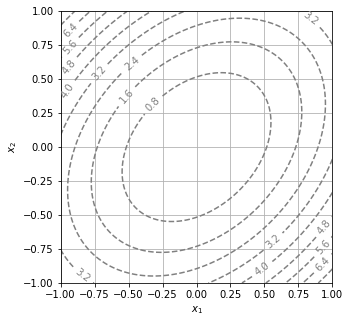

In [11]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [12]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

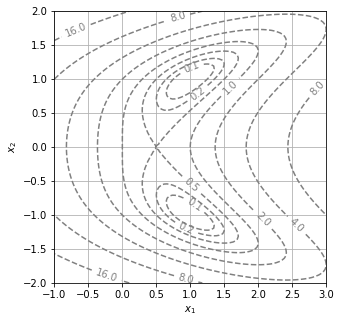

In [13]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [14]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

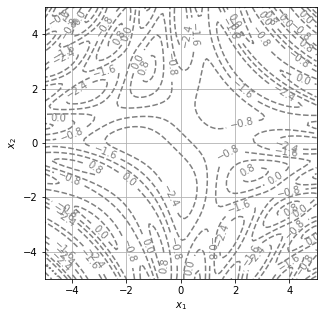

In [15]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [16]:
#On étudie ici (la plupart du temps) des fonction qui respectent 
#les hypothèses du théorème des fonctions implicites. 

#Il ne faudra donc pas une valeur de eps excessivement grande, 
#car quand on est proche de la solution exacte, 
#on est assuré d'être relativement proche de zéro.

#On est donc permit de choisir une valeur "assez grande",
#qui garantit rapidité à la fonction Newton, 
#centrale dans la suite de notre problème

#On perd tout de même légèrement en précision quand eps augmente trop
#Après quelques tests on prend un bon compromis:

eps = 10**(-5)

#On prend un jsute milieu pour N après quelques tests de rapidité:

N = 100

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [17]:
def Newton(F, x0, y0, eps=eps, N=N):
    
    for i in range(N):
        J_F = J(F)
        tab = J_F(x0,y0)
        det = np.linalg.det(tab)
        
        if np.isclose(det, 0.):
            x0 += (1/10)*x0 
        #on essaye de pallier le problème de matrice non inversible 
        #en recherchant une solution "à coté"
        else:
            tab_inv = np.linalg.inv(tab)
            x, y = (x0 - np.dot(tab_inv, F(x0,y0) )[0]), (y0 - np.dot(tab_inv, F(x0,y0) )[1])
        
            if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
                return x, y
        x0, y0 = x, y
    
    raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

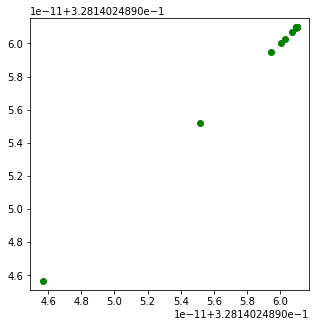

In [18]:
def test_Newton(Xo, Yo, contrainte, ldn, f_ref): 

    #renvoie un graphe localisant les solutions du problème.
    
    #Xo et Yo sont les liste des points de références que l'on veut tester, 
    #on utilise tout les couples formés d'élément des deux listes
    
    #contrainte est une fonction prenant en compte la contraite désirée
    #exemple : pour x=y on prendra la fonction qui à (x,y) associe x-y.
    
    #ldn est la valeur de la ligne de niveau désirée
    #f_ref est la fonction étudiée

    X = []
    Y = []
 
    def F(x,y):
        return( np.array( [ f_ref(x,y)-ldn , contrainte(x,y) ]) ) 
    
    for ex in Xo: 
        for ey in Yo:
            point = Newton(F,ex,ey)
            X.append(point[0])
            Y.append(point[1])    
                
    #Tracé d'un nuage de points si la fonction Newton a partout convergé
    plt.scatter(X,Y, c = 'green')
    plt.axis('equal')
    plt.show()
    

    
    

#Une illustration de l'usage de test_Newton : 
#Pour f1, avec les lignes de niveau de l'exemple introductif
#et la contrainte x = y

#On remarque que à la distance eps pret, 
#on aboutit à la meme solution pour chaque point de départ
#Mais il faut noter les légers écarts (jusqu'à 1e-10) entre ces dernières

points = [0.5, 0.6, 0.7, 0.8]
def contrainte(x,y):
    return(x-y)


test_Newton(points, points, contrainte, 0.5, f2)









### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [20]:
#Les explications sont sur level_curve2.
#Après tests sur f3, la fonction level_curve2 est bien plus performante.

def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    tab = np.empty((2,N))
    tab[:, 0] = np.array([x0, y0])
    u, v = x0, y0
    sensgrad = -1.
    c = f(x0, y0)
    
    for k in range(1, N):
        grad_f = grad(f)
        gradient = grad_f(u,v)
        
        def F(a,b):
                return np.array([(f(a,b) - c), (np.sqrt((u - a)**2 + (v - b)**2) - delta)])
        
        if np.isclose(gradient[0], 0.):
            u2 = u + delta
            v2 = v
            u, v = Newton(F, u2, v2)      
        
        else:
            sol1v = - delta/(np.sqrt(1 + (gradient[1]/gradient[0])**2))
            sol1u = - (gradient[1]/gradient[0])*sol1v
            normegrad = np.sqrt(gradient[0]**2 + gradient[1]**2)
            norme = np.sqrt(sol1u**2 + sol1v**2)
            if np.dot(grad_f(tab[0,k-2], tab[1,k-2]), grad_f(tab[0,k-1], tab[1,k-1])) <0:
                sensgrad = -sensgrad
            mat = np.array( [ [gradient[0]/normegrad, sol1u/norme ], [gradient[1]/normegrad, sol1v/norme ]])
            det = np.linalg.det(mat)
            if np.isclose(det, sensgrad):    
                u2 = sol1u + u
                v2 = sol1v + v  
            else: 
                u2 =- sol1u + u
                v2 =- sol1v + v        
            u,v = Newton(F,u2,v2) #En se reprojetant
            
        #u,v=u2,v2 #Sans se reprojeter sur la courbe
        tab[:,k] = np.array([u,v])
    
    return tab








### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [21]:
def level_curve2(f, x0, y0, delta=0.1, N=1000, eps=eps):
    tab = np.empty((2,N))
    tab[:, 0] = np.array([x0, y0])
    u, v = x0, y0
    sensgrad = -1.
    c = f(x0, y0) #Indique le sens dans lequel on tourne
    
    for k in range(1, N):
        grad_f = grad(f)
        gradient = grad_f(u, v)
        
        #On définit la fonction sur laquelle on va appliquer Newton : On retourne sur la courbe de niveau,
        #à une distance delta du point précédent.
        def F(a, b): 
                return np.array([(f(a,b) - c), (np.sqrt((u - a)**2 + (v - b)**2) - delta)])
            
        if (k >= 10) and (np.sqrt((v - tab[1,0])**2 + (u - tab[0,0])**2) <= delta): #Condition pour s'arrêter
            tab[0,k:]=tab[0,0]
            tab[1,k:]=tab[1,0]
            return(tab)
        
        elif np.isclose(gradient[0], 0.) : #Dans le cas où une composante du gradient est nulle
            u2 = u + delta
            v2 = v
            u, v = Newton(F, u2, v2)
                
        else :
            sol1v = - delta/np.sqrt(1 + (gradient[1]/gradient[0])**2)
            sol1u = - (gradient[1]/gradient[0])*sol1v
            normegrad = np.sqrt(gradient[0]**2 + gradient[1]**2)
            norme = np.sqrt(sol1u**2 + sol1v**2)
            if k >= 3 and np.dot(grad_f(tab[0,k-2], tab[1,k-2]), grad_f(tab[0,k-1], tab[1,k-1])) <0: 
                #Si le gradient change d'un coup de signe à cause d'un noeud par exemple,
                #on doit changer de sens dans lequel on tourne sinon on fait demi-tour indéfiniment.
                sensgrad = - sensgrad
            mat = np.array([ [gradient[0]/normegrad, sol1u/norme ], [gradient[1]/normegrad, sol1v/norme] ])
            det = np.linalg.det(mat)
            if np.isclose(det, sensgrad):  
                #L'idée est de regarder la matrice de
                #passage de la base orthonormée canonique dans celle crée et de voir si de déterminant +1, 
                #sinon on change la sol, car ça veut dire qu'on a une base indirecte, et donc qu'on part vers la gauche.   
                u2 = sol1u + u
                v2 = sol1v + v  
            else: 
                u2 =- sol1u + u
                v2 =- sol1v + v
            u,v = Newton(F, u2, v2) 
            #On se reprojette sur la courbe de niveau après s'être décalé.
            #u,v=u2,v2 
            #Il y a aussi une version sans se reprojeter sur la courbe : accumulation d'erreur
            #mais moins de problèmes pour des fonctions complexes comme f3. 
        
        tab[:,k] = np.array([u,v])
    return (tab)


**Question** Valider graphiquement le résultat au moyen des exemples de référence.

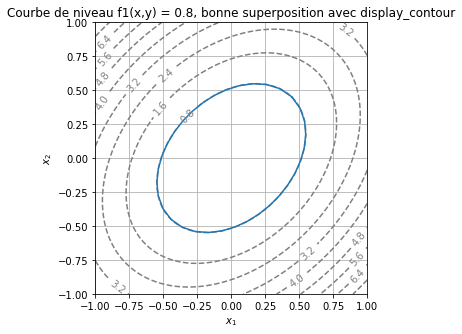

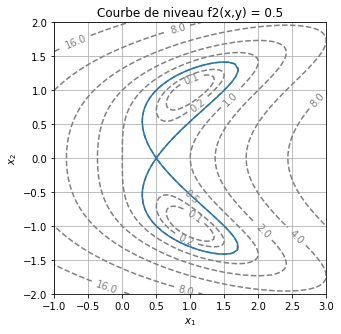

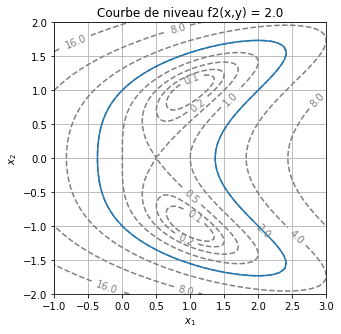

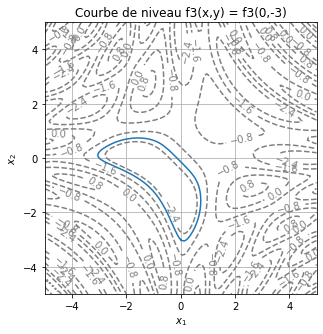

In [22]:
#Avec la fonction f1, classique:
#La courbe de niveau par level_curve2: 
def F1(x,y):
    return np.array([f1(x,y)-0.8, x-y])  
x0,y0=Newton(F1, 0.8, 0.8) #Courbe de niveau 0.8
tab=level_curve2(f1, x0, y0, delta=0.1, N=1000)
X=tab[0,:]
Y=tab[1,:]
#On superpose les niveaux proposés par display_contour: 
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 
)
plt.title('Courbe de niveau f1(x,y) = 0.8, bonne superposition avec display_contour')
plt.plot(X,Y);





#Avec la fonction f2, où ça fait un noeud :
def F2(x,y):
    return np.array([f2(x,y)-0.5, x-y])  
x0,y0=Newton(F2, 0.8, 0.8) #Courbe de niveau 0.5
tab=level_curve2(f2, x0, y0, delta=0.1, N=1000) #On augmente la précision et le nombre de points pour que ça suive bien
X=tab[0,:]
Y=tab[1,:]
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.title('Courbe de niveau f2(x,y) = 0.5')
plt.plot(X,Y);



#Avec f2 sans le noeud :
def F2_bis(x,y):
    return np.array([f2(x,y)-2., x-y]) 
x0, y0 = Newton(F2_bis, 0.8, 0.8) #Courbe de niveau 0.5
tab = level_curve2(f2, x0, y0, delta=0.1, N=1000) #On augmente la précision et le nombre de points pour que ça suive bien
X = tab[0,:]
Y = tab[1,:]   
display_contour(
    f2, 
    x = np.linspace(-1.0, 3.0, 100), 
    y = np.linspace(-2.0, 2.0, 100), 
    levels = [2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.title('Courbe de niveau f2(x,y) = 2.0')
plt.plot(X,Y);





#Avec la fonction f3:
tab3 = level_curve2(f3, 0., -3.) 
X3=tab3[0,:]
Y3=tab3[1,:]
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
plt.title('Courbe de niveau f3(x,y) = f3(0,-3)')
plt.plot(X3,Y3);


# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

L'aire du disque unité est environ 3.142800 (précision h=0.01)


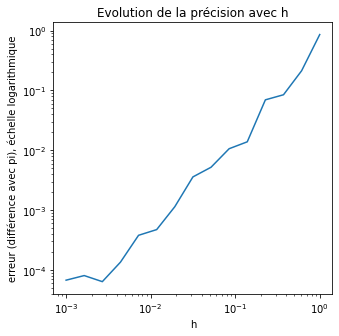

In [23]:
#Méthode des carrés : On s'est permis de rajouter des paramètres 
#afin de prendre un carré le plus petit possible 
#(on trace la courbe de niveau associée à la valeur c 
#et on regarde dans quoi varie les abscisses et les ordonnées).

def area_squares(f, c, h, x0, y0): 
    #x0,y0 sont les coordonnées d'un point de la courbe de niveau f(x,y)=c 
    #dont on veut mesurer l'aire.
    K = level_curve2(f, x0, y0)
    #On regarde les bornes du gros carré :
    tabmax = K.max(axis = 1) #On obtient un truc de taille (2,)
    tabmin = K.min(axis = 1) #Idem
    cote = max(abs(tabmax[0] - tabmin[0]), abs(tabmax[1] - tabmin[1])) #Taille du côté du carré.

    Lx = [tabmin[0] + h/2+k*h for k in range(0,int(cote/h)+2)] #On définit les abcisses de tous les centres
    tabx = np.array(Lx)
    Ly = [tabmin[1]+h/2 +i*h for i in range(0,int(cote/h)+2)] # idem pour les ordonnées
    taby = np.array(Ly)
    
    #On reshape pour que le broadcast fait en sorte d'avoir tous les points du carré
    #(vecteur ligne + vectteur colonne donne matrice)
    #On fait un masque pour mettre True seulement sur ceux qui sont dans K
    tabbool = f(tabx,taby.reshape(-1,1)) <= c 
    tot = tabbool[tabbool == True].size 
    
    return tot*h**2 #On retourne l'aire totale.





#Deux fonctions utiles:
def cercle(x,y):
    return(np.sqrt(x**2+y**2))

def F(x,y):
    return(np.array([cercle(x,y)-1.,x-y]))





#Test de la fonction: 
x0, y0 = Newton(F,1.,1.)
h = 0.01
print(f"L'aire du disque unité est environ {area_squares(cercle,1.,h,x0,y0):.6f} (précision h={h})")




#Traçons l'évolution de la précision avec h:
x = np.logspace(-3,0,15)
y = np.array( [abs(area_squares(cercle,1.,h,x0,y0)-np.pi) for h in x] )
plt.loglog(x,y);
plt.title('Evolution de la précision avec h')
plt.xlabel('h') 
plt.ylabel('erreur (différence avec pi), échelle logarithmique'); 

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [25]:
#Pour obtenir une minoration, on regarde sur le petit carré est tout entier
#dans la courbe de niveau, ie que l'on regarde si les 4 sommets du carré 
#sont dedans ou non. Si non, on ne le compte pas.

def area_squares_mino(f, c, h, x0, y0):
    K = level_curve2(f, x0, y0)
    tabmax = K.max(axis = 1)
    tabmin = K.min(axis = 1)
    cote = max(abs(tabmax[0]-tabmin[0]), abs(tabmax[1]-tabmin[1]))
    
    Lx = [tabmin[0] + h/2 + k*h for k in range(0,int(cote/h)+2)]
    tabx = np.array(Lx)
    Ly = [tabmin[1] + h/2 + i*h for i in range(0,int(cote/h)+2)]
    taby = np.array(Ly)
    
    #Condition à rallonge, On a 4 "et" car 4sommets. :
    tabbool = np.logical_and(np.logical_and(f(tabx + h/2 ,taby.reshape(-1,1) + h/2 )<=c, f(tabx + h/2 ,taby.reshape(-1,1) - h/2 )<=c) , np.logical_and(f(tabx - h/2 ,taby.reshape(-1,1) - h/2 )<=c , f(tabx - h/2 ,taby.reshape(-1,1) + h/2 )<=c) ) 
    tot = tabbool[tabbool == True].size
   
    return tot*h**2




#Test de la fonction:
hmajo=0.01
hmino=0.0002
print(f"L'aire du cercle unité est comprise entre : {area_squares_mino(cercle,1.,hmino,x0,y0):.3f} (hmino={hmino}) <= Aire <= {area_squares(cercle,1.,h,x0,y0):.3f} (hmajo={hmajo})" )

L'aire du cercle unité est comprise entre : 3.141 (hmino=0.0002) <= Aire <= 3.143 (hmajo=0.01)


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

L'aire du disque unité est 3.136378488531686 (delta=0.1) 



Text(0.5, 1.0, "Evolution de l'erreur avec delta")

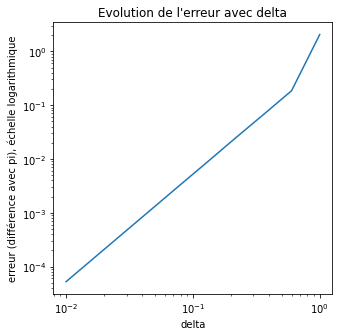

In [26]:
#L'idée est de faire le produit vectoriel entre vect(pzi) et vect(pzi+1),
#on obtient l'aire de paralélogramme signée, et il suffit de diviser par 2.
def area_triangle(niv,p): 
    #Niv est un tableau (2,n) avec tous les points de l'ensemble.
    nb = niv.shape[1] #Le nombre de points
    Aire = 0
    
    for k in range(1,nb):
        vecta = np.array([niv[0,k]-p[0],niv[1,k]-p[1]])
        vectb = np.array([niv[0,k-1]-p[0],niv[1,k-1]-p[1]])
        Aire += np.cross(vecta,vectb)/2 
        #Dans ce sens pour que ça soit positif 
        #car la courbe est décrite sens horaire
    
    #Quand on a terminé la boucle for, il nous reste le dernier triangle
    #construit avec le dernier et le premier point.
    Aire = Aire + np.cross(np.array([niv[0,0] - p[0], niv[1,0] - p[1]]), [niv[0,-1] - p[0], niv[1,-1] - p[1]])/2
    
    return Aire



#Exemple avec le cercle unité :
x0, y0 = Newton(F, 1., 1.)
niv = level_curve2(cercle, x0,y0) #On trace la courbe de niveau pour avoir des points.
p = np.array([0,0])
print(f"L'aire du disque unité est {area_triangle(niv,p)} (delta=0.1) \n")



# Regardons l'évolution de l'erreur avec delta:
delta = np.logspace(-2,0,10) #On fait varier delta enre 0.01 et 1 uniformément sur échelle log
y = np.array([abs(area_triangle(level_curve2(cercle,x0,y0,delt), np.array([0,0])) - np.pi) for delt in delta ])
plt.loglog(delta,y)
plt.xlabel('delta') 
plt.ylabel('erreur (différence avec pi), échelle logarithmique')
plt.title("Evolution de l'erreur avec delta")

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [27]:
print(f" On prend p=(2,2), ça marche quand même : Aire={area_triangle(niv, np.array( [2,2]))}")
#Ok ça marche, c'est du au fait qu'on utilise un produit vectoriel, 
#qui fournit une aire signée selon que les deux vecteurs ont un angle positif ou négatif entre eux.

 On prend p=(2,2), ça marche quand même : Aire=3.136378488531685


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [28]:
def cercletrans(x, y): #Cercle translaté de 2
    return np.sqrt((x - 2.)**2 + (y - 2.)**2)

def Ftrans(x, y): #Fonction F associée
    return np.array([cercletrans(x,y)-1.,x-y]) 

x0, y0 = Newton(F, 1., 1.)
x1, y1 = Newton(Ftrans, 3., 3.)

tab1 = level_curve2(cercle, x0, y0)
tab2 = level_curve2(cercletrans, x1, y1) #On trace les courbesde niveaux

#On se débrouille pour les concaténer correctement :
niv1 = np.concatenate((tab1[0,:], tab2[0,:]))
niv2 = np.concatenate((tab1[1,:], tab2[1,:])) 
niv=np.empty((2, niv1.shape[0]))
niv[0,:] = niv1
niv[1,:] = niv2

print(f"L'aire de ces deux cercles (avec p=(0,0)) est : {area_triangle(niv,np.array([0,0]) )}" )

L'aire de ces deux cercles (avec p=(0,0)) est : 6.27275697706337


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [29]:
#C'est pas ce qu'on vient de faire déjà ?
#On ne voit pas comment comparer les deux méthodes : sur l'une on fait 
#varier h, et sur l'autre c'est delta, qui ne semble rien à voir avec h.